In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from astropy.wcs import WCS
from scipy.fftpack import fft2, fftshift
from matplotlib.patches import Circle
from scipy.signal import resample
from scipy.signal import find_peaks
from matplotlib.patches import Wedge
from turbustat.statistics import PowerSpectrum
import emcee
from scipy.ndimage import gaussian_filter
import webbpsf
from scipy.ndimage import zoom
from scipy.signal import convolve2d

base_dir = "/export/home/extragal/francesco.chititegli/JWST/TESI/"

# Visualize FITS

Filename: /export/home/extragal/francesco.chititegli/JWST/TESI/hlsp_phangs-jwst_jwst_miri_ngc0628_f2100w_v1p1_img.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     360   ()      
  1  SCI           1 ImageHDU        75   (1891, 2600)   float32   
  2  ERR           1 ImageHDU        10   (1891, 2600)   float32   
  3  CON           1 ImageHDU        10   (1891, 2600, 1)   int32   
  4  WHT           1 ImageHDU         9   (1891, 2600)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (1891, 2600)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (1891, 2600)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (1891, 2600)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [129942B]   
Unit: MJy/sr


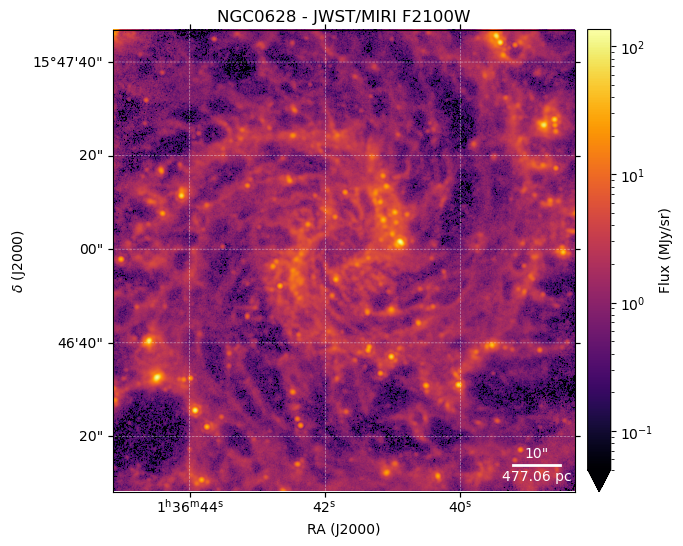

In [6]:
with fits.open(os.path.join(base_dir, "hlsp_phangs-jwst_jwst_miri_ngc0628_f2100w_v1p1_img.fits")) as hdul:
    hdul.info()
    header = hdul[1].header
    image_data = hdul[1].data
wcs = WCS(header)
flux_unit = header.get("BUNIT", "Unknown Unit") 
print('Unit: ' + str(flux_unit))

# I am preliminarly using a cropped frame, as the full frame is rotated wrt the FOV
y_min, y_max = 680, 1570
x_min, x_max = 430, 1320
seb = 400
cropped_image = image_data[y_min:y_max, x_min:x_max]
wcs_cropped = wcs[y_min:y_max, x_min:x_max]

# [y_min:y_max, x_min:x_max]
# [y_min+seb-80:y_max-seb-80, x_min+seb-30:x_max-seb-30]

distance_ngc628 = 9.84 * 10**6
arcsecond_to_pc = distance_ngc628 / 206265
pixel_scale = np.abs(wcs_cropped.wcs.cdelt[0]) * 3600
arcsecond_length_in_pixels = 1 / pixel_scale

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': wcs_cropped}, dpi=100)
cmap = plt.cm.inferno.copy()
cmap.set_bad(color='black')

im = ax.imshow(cropped_image, cmap=cmap, origin="lower", norm=plt.matplotlib.colors.LogNorm(vmin=5e-2, vmax=cropped_image.max()))
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("$\delta$ (J2000)")
ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.5)

x_start = cropped_image.shape[1] - 120
y_position = 50
ax.plot([x_start, x_start + (arcsecond_length_in_pixels*10)], [y_position, y_position], color='white', lw=2)
ax.text(x_start + (arcsecond_length_in_pixels*10) / 2, y_position + 10, "10\"", color='white', va='bottom', ha='center', fontsize=10)
ax.text(x_start + (arcsecond_length_in_pixels*10) / 2, y_position - 20, f"{(arcsecond_to_pc*10):.2f} pc", color='white', va='center', ha='center', fontsize=10)

ax.set_title(f"NGC0628 - JWST/MIRI F2100W")
cbar = plt.colorbar(im, ax=ax, pad=0.02, extend='min')
cbar.set_label(f"Flux ({flux_unit})")
plt.show()

In [37]:
miri_images = {
    "F770W": "hlsp_phangs-jwst_jwst_miri_ngc0628_f770w_v1p1_img.fits",
    "F1000W": "hlsp_phangs-jwst_jwst_miri_ngc0628_f1000w_v1p1_img.fits",
    "F1130W": "hlsp_phangs-jwst_jwst_miri_ngc0628_f1130w_v1p1_img.fits",
    "F2100W": "hlsp_phangs-jwst_jwst_miri_ngc0628_f2100w_v1p1_img.fits",
}
miri_psf = [0.269, 0.328, 0.375, 0.674]

#    "MUSE_Halfa": "NGC0628_MAPS_copt_0.92asec.fits",
#    "MUSE_Halfa_NATIVE": "NGC0628_MAPS_native.fits",
# 0.8, 0.8

In [39]:
for i, (filter_name, _) in enumerate(miri_images.items()):
    print(str(filter_name) + ' PSF:  ' + str(miri_psf[i]) + ' arcsec; ' + str(miri_psf[i] * arcsecond_to_pc) + ' pc')

F770W PSF:  0.269 arcsec; 12.832812159115702 pc
F1000W PSF:  0.328 arcsec; 15.647443822267473 pc
F1130W PSF:  0.375 arcsec; 17.88960802850702 pc
F2100W PSF:  0.674 arcsec; 32.153588829903285 pc


0.12499005027147952


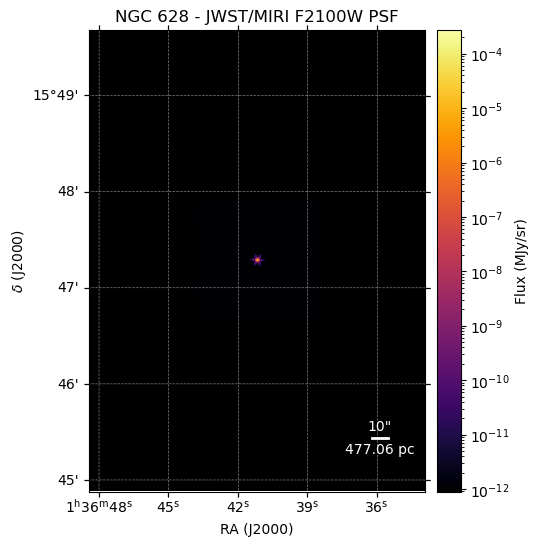

In [45]:
def create_psf_image_gauss(input_image, fwhm, pixel_scale_arcsec):
    sigma_pixels = fwhm / (2.355 * pixel_scale_arcsec)
    psf_image = np.zeros_like(input_image)

    center_y, center_x = np.array(psf_image.shape) // 2
    psf_image[center_y, center_x] = 1.0
    psf_image = gaussian_filter(psf_image, sigma=sigma_pixels)
    psf_image /= np.sum(psf_image)

    nan_mask = np.isnan(input_image)
    psf_image[nan_mask] = np.nan

    return psf_image

def create_psf_image_JWST(input_image, filter_name, pixel_scale_arcsec, fov_arcsec=80, oversample=8):
    miri = webbpsf.MIRI()
    miri.filter = filter_name
    psf_hdulist = miri.calc_psf(fov_arcsec=fov_arcsec, oversample=oversample)
    psf_image = psf_hdulist[0].data
    
    psf_pixel_scale = psf_hdulist[0].header['PIXELSCL']
    scale_factor = psf_pixel_scale / pixel_scale_arcsec
    print(scale_factor)

    psf_image_resized = zoom(psf_image, scale_factor, order=3)

    psf_center_y, psf_center_x = np.array(psf_image_resized.shape) // 2
    image_center_y, image_center_x = np.array(input_image.shape) // 2
    y_offset = image_center_y - psf_center_y
    x_offset = image_center_x - psf_center_x
    psf_image_full = np.zeros_like(input_image)
    psf_image_full[max(0, y_offset):max(0, y_offset)+psf_image_resized.shape[0],
                   max(0, x_offset):max(0, x_offset)+psf_image_resized.shape[1]] = psf_image_resized
    nan_mask = np.isnan(input_image)
    psf_image_full[nan_mask] = np.nan
    
    return psf_image_full

#cropped_image_PSF = create_psf_image_gauss(cropped_image, miri_psf[0], pixel_scale)
cropped_image_PSF = create_psf_image_JWST(cropped_image, 'F2100W', pixel_scale)

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': wcs_cropped}, dpi=100)
cmap = plt.cm.inferno.copy()
cmap.set_bad(color='black')

im = ax.imshow(cropped_image_PSF, cmap=cmap, origin="lower", norm=plt.matplotlib.colors.LogNorm())
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("$\delta$ (J2000)")
ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.5)

x_start = cropped_image_PSF.shape[1] - 300
y_position = 300
ax.plot([x_start, x_start + (arcsecond_length_in_pixels*10)], [y_position, y_position], color='white', lw=2)
ax.text(x_start + (arcsecond_length_in_pixels*10) / 2, y_position + 30, "10\"", color='white', va='bottom', ha='center', fontsize=10)
ax.text(x_start + (arcsecond_length_in_pixels*10) / 2, y_position - 60, f"{(arcsecond_to_pc*10):.2f} pc", color='white', va='center', ha='center', fontsize=10)

ax.set_title(f"NGC 628 - JWST/MIRI F2100W PSF")
cbar = plt.colorbar(im, ax=ax, pad=0.02)
cbar.set_label(f"Flux ({flux_unit})")
plt.show()

In [ ]:
def create_noise_image_gaussian(input_image, fwhm_psf, pixel_scale_arcsec, signal_filter_size=5):
    sigma_pixels = fwhm_psf / (2.355 * pixel_scale_arcsec)
    
    signal_estimate = gaussian_filter(input_image, sigma=sigma_pixels)

    noise_image = input_image - signal_estimate

    nan_mask = np.isnan(input_image)
    noise_image[nan_mask] = np.nan
    
    return noise_image

def create_noise_image_PSF(input_image, filter_name, pixel_scale_arcsec, fov_arcsec=80, oversample=8):
    miri = webbpsf.MIRI()
    miri.filter = filter_name
    psf_hdulist = miri.calc_psf(fov_arcsec=fov_arcsec, oversample=oversample)
    psf_image = psf_hdulist[0].data

    psf_pixel_scale = psf_hdulist[0].header['PIXELSCL']
    scale_factor = psf_pixel_scale / pixel_scale_arcsec
    print(f"Scale factor for resizing PSF: {scale_factor}")
    psf_image_resized = zoom(psf_image, scale_factor, order=3)

    signal_estimate = convolve2d(input_image, psf_image_resized, mode='same', boundary='symm')

    noise_image = input_image - signal_estimate

    nan_mask = np.isnan(input_image)
    noise_image[nan_mask] = np.nan
    
    return noise_image

#cropped_image_noise = create_noise_image_gaussian(cropped_image,  miri_psf[0], pixel_scale)
cropped_image_noise = create_noise_image_PSF(cropped_image, 'F2100W', pixel_scale)

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': wcs_cropped}, dpi=100)
cmap = plt.cm.inferno.copy()
cmap.set_bad(color='black')

im = ax.imshow(cropped_image_noise, cmap=cmap, origin="lower", norm=plt.matplotlib.colors.LogNorm())
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("$\delta$ (J2000)")
ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.5)

x_start = cropped_image_PSF.shape[1] - 300
y_position = 300
ax.plot([x_start, x_start + (arcsecond_length_in_pixels*10)], [y_position, y_position], color='white', lw=2)
ax.text(x_start + (arcsecond_length_in_pixels*10) / 2, y_position + 30, "10\"", color='white', va='bottom', ha='center', fontsize=10)
ax.text(x_start + (arcsecond_length_in_pixels*10) / 2, y_position - 60, f"{(arcsecond_to_pc*10):.2f} pc", color='white', va='center', ha='center', fontsize=10)

ax.set_title(f"NGC 628 - JWST/MIRI F770W sub-PSF Noise")
cbar = plt.colorbar(im, ax=ax, pad=0.02)
cbar.set_label(f"Flux ({flux_unit})")
plt.show()

Scale factor for resizing PSF: 0.12499005027147952


# Prova Power Spectrum

/export/home/extragal/francesco.chititegli/.local/lib/python3.11/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")


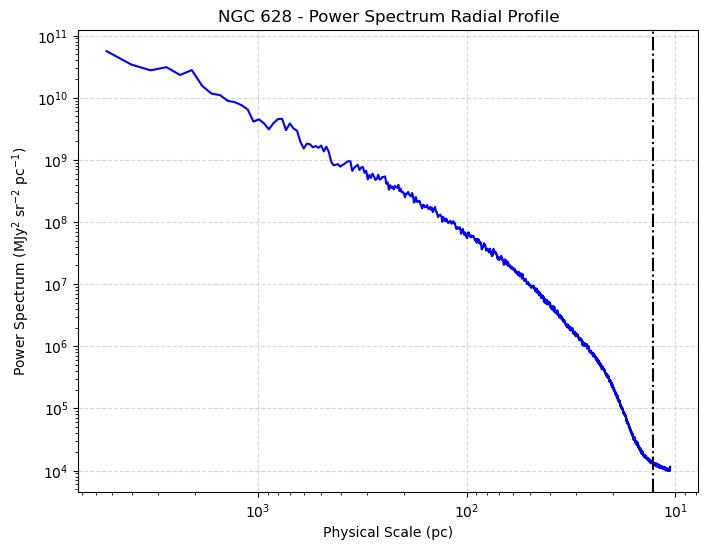

/export/home/extragal/francesco.chititegli/.local/lib/python3.11/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/export/home/extragal/francesco.chititegli/.local/lib/python3.11/site-packages/turbustat/statistics/base_pspec2.py:483: UserWarning: The elliptical parameter is close to 1. The field may be isotropic and the fit is not converging to 1. Consider fitting with `fix_ellip_params=True`, which forces the ellipticity to 1.
  warnings.warn("The elliptical parameter is close to 1. The field "


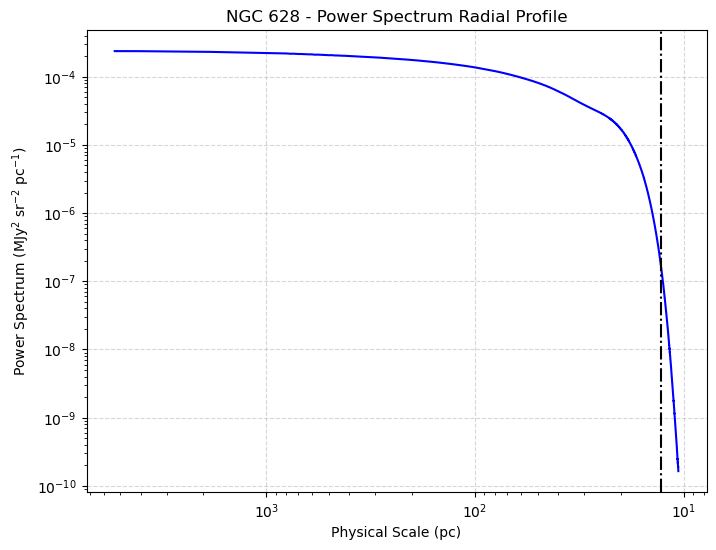

/export/home/extragal/francesco.chititegli/.local/lib/python3.11/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")


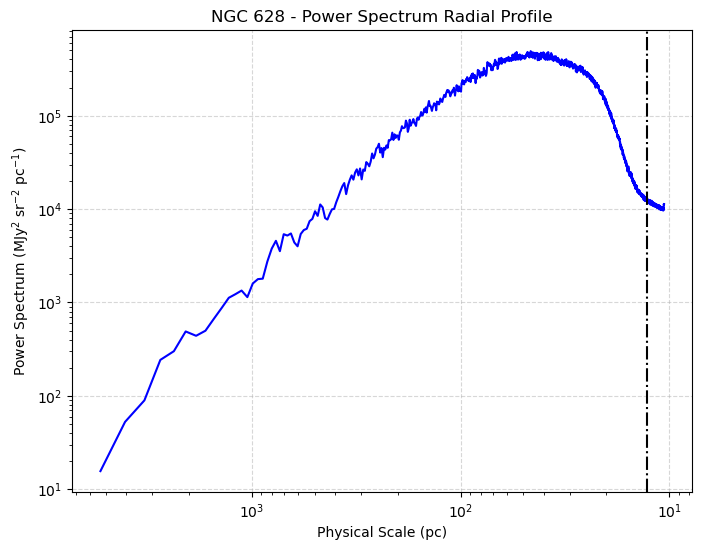

In [30]:
def compute_power_spectrum(image):
    fft_image = np.fft.fft2(image)
    fft_shifted = np.fft.fftshift(fft_image)
    power_spectrum = np.abs(fft_image) ** 2
    power_spectrum = np.nan_to_num(power_spectrum)
    
    y, x = np.indices(image.shape)
    center = np.array(image.shape) // 2
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    r = r.astype(int)
    
    radial_profile = np.bincount(r.ravel(), power_spectrum.ravel()) / np.bincount(r.ravel())
    k = np.arange(len(radial_profile))
    
    return k, radial_profile

def compute_power_spectrum_koch(image, header_infunc):
    apodization = np.hanning(image.shape[0])[:, None] * np.hanning(image.shape[1])
    image_apodized = image * apodization

    pspec = PowerSpectrum(image_apodized, header_infunc)
    pspec.run(verbose=False)
    
    k = pspec.freqs
    power_spectrum = pspec.ps1D

    return k, power_spectrum

def resample_power_spectrum(k, power_spectrum, fraction):
    num_points = int(len(k) * fraction)
    indices = np.linspace(0, len(k) - 1, num_points, dtype=int)
    return k[indices], power_spectrum[indices]

def plot_power_spectrum(k, power_spectrum, wcs):
    pixel_scale_x = np.abs(wcs.wcs.cdelt[0]) * 3600
    pixel_scale_y = np.abs(wcs.wcs.cdelt[1]) * 3600
    pixel_scale = np.sqrt(pixel_scale_x * pixel_scale_y)
    arcsecond_length_in_pixels = 1 / pixel_scale

    spatial_scale = (k.value[1:])**(-1) * arcsecond_to_pc * pixel_scale_x
    angular_scale = 1 / (k.value[1:] * pixel_scale)
    wavenumbers_scale = k.value[1:] * pixel_scale
    
    plt.figure(figsize=(8, 6))
    plt.plot(spatial_scale, power_spectrum[1:], label='Radial Profile', color='blue')
    #plt.axvline(x= 41.6426, color='black', linestyle='--')
    #plt.fill_betweenx([-1e30, 1e30], 41.6426-5, 41.6426+15, color='gray', alpha=0.5)
    plt.axvline(x= (miri_psf[0] * arcsecond_to_pc), color='black', linestyle='-.')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Physical Scale (pc)")
    #plt.ylim(1e3,2.5e9)
    #plt.xlim(1e1,2e4)
    plt.ylabel("Power Spectrum (MJy$^{2}$ sr$^{-2}$ pc$^{-1}$)")
    plt.title("NGC 628 - Power Spectrum Radial Profile")
    plt.gca().invert_xaxis()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

'''
def plot_derivative_power_spectrum(k, power_spectrum):
    pixel_scale_x = np.abs(wcs.wcs.cdelt[0]) * 3600
    pixel_scale_y = np.abs(wcs.wcs.cdelt[1]) * 3600
    pixel_scale = np.sqrt(pixel_scale_x * pixel_scale_y)
    
    spatial_scale = (k.value[1:])**(-1) * arcsecond_to_pc * pixel_scale
    angular_scale = 1 / (k.value[1:] * pixel_scale)
    wavenumbers_scale = k.value[1:] * pixel_scale
    print(601*pixel_scale)
    print(601*arcsecond_length_in_pixels)
    
    log_r = np.log10(spatial_scale)
    log_P = np.log10(power_spectrum[1:])
    dlogP_dlogr = np.gradient(-log_P, log_r, edge_order=2)

    print(find_peaks(-dlogP_dlogr, 10))
    print(spatial_scale[7])
    print((k.value[7])**(-1))

    plt.figure(figsize=(8, 6))
    plt.plot(spatial_scale, dlogP_dlogr, label="Power Spectrum Derivative", color='red')
    plt.axhline(y=-5/3, color='black', linestyle='--', label="Kolmogorov (-5/3)")
    plt.axhline(y=-3/2, color='blue', linestyle='--', label="Iroshnikov-Kraichnan (-3/2)")
    plt.axhline(y=-2, color='orange', linestyle='--', label="Burgers (-2)")
    plt.axvline(x= 41.6426, color='black', linestyle='--')
    plt.fill_betweenx([-1e30, 1e30], 41.6426-5, 41.6426+15, color='gray', alpha=0.5)
    plt.xscale("log")
    plt.xlabel("Physical Scale (pc)")
    plt.ylabel("d(log P) / d(log r)")
    plt.title("NGC 628 - Power Spectrum Radial Profile Log Derivative")
    plt.ylim(-15,4)
    plt.legend()
    plt.gca().invert_xaxis()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
'''
k, power_spectrum = compute_power_spectrum_koch(cropped_image, header)
k_resampled, power_resampled = resample_power_spectrum(k, power_spectrum, 1)
plot_power_spectrum(k_resampled, power_resampled, wcs_cropped)

k_PSF, power_spectrum_PSF = compute_power_spectrum_koch(cropped_image_PSF, header)
k_resampled_PSF, power_resampled_PSF = resample_power_spectrum(k_PSF, power_spectrum_PSF, 1)
plot_power_spectrum(k_resampled_PSF, power_resampled_PSF, wcs_cropped)

k_noise, power_spectrum_noise = compute_power_spectrum_koch(cropped_image_noise, header)
k_resampled_noise, power_resampled_noise = resample_power_spectrum(k_noise, power_spectrum_noise, 1)
plot_power_spectrum(k_resampled_noise, power_resampled_noise, wcs_cropped)

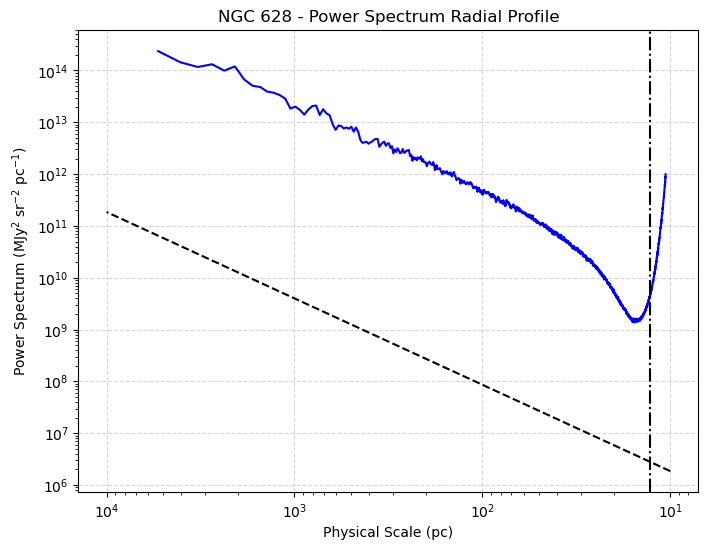

In [34]:
def plot_power_spectrum(k, power_spectrum, wcs):
    pixel_scale_x = np.abs(wcs.wcs.cdelt[0]) * 3600
    pixel_scale_y = np.abs(wcs.wcs.cdelt[1]) * 3600
    pixel_scale = np.sqrt(pixel_scale_x * pixel_scale_y)
    arcsecond_length_in_pixels = 1 / pixel_scale

    spatial_scale = (k.value[1:])**(-1) * arcsecond_to_pc * pixel_scale_x
    angular_scale = 1 / (k.value[1:] * pixel_scale)
    wavenumbers_scale = k.value[1:] * pixel_scale
    
    plt.figure(figsize=(8, 6))
    plt.plot(spatial_scale, power_spectrum[1:], label='Radial Profile', color='blue')
    #plt.axvline(x= 41.6426, color='black', linestyle='--')
    #plt.fill_betweenx([-1e30, 1e30], 41.6426-5, 41.6426+15, color='gray', alpha=0.5)
    plt.axvline(x= (miri_psf[0] * arcsecond_to_pc), color='black', linestyle='-.')

    k_range = np.logspace(1, 4, 100)
    k_line = A = 4e4 * k_range ** (5/3)
    plt.plot(k_range, k_line, label="Kolmogorov", color='black', linestyle='--')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Physical Scale (pc)")
    #plt.ylim(1e3,2.5e9)
    #plt.xlim(1e1,2e4)
    plt.ylabel("Power Spectrum (MJy$^{2}$ sr$^{-2}$ pc$^{-1}$)")
    plt.title("NGC 628 - Power Spectrum Radial Profile")
    plt.gca().invert_xaxis()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

plot_power_spectrum(k_resampled_PSF, power_resampled/power_resampled_PSF - power_resampled_noise/power_resampled_PSF, wcs_cropped)

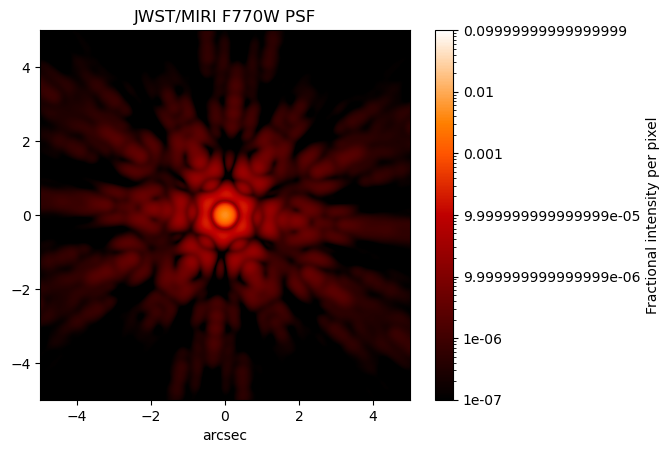

In [9]:
# Istanzia lo strumento JWST/MIRI
miri = webbpsf.MIRI()

# Imposta il filtro (puoi cambiare in 'F1000W', 'F1130W', ecc.)
webbpsf.MIRI().filter = 'F770W'

# Oversampling: pixel per lambda/D (tipicamente 4–8)
# field_position: (x, y) in arcsec sul campo (opzionale)
psf = miri.calc_psf(oversample=4, fov_arcsec=10)

# Mostra la PSF
webbpsf.display_psf(psf, title='JWST/MIRI F770W PSF')

# Power spectrum for MIRI filters and Halpha MUSE

In [7]:
power_spectra_MIRI = []
power_spectra_PSF = []
i = 0

for filter_name, file_path in miri_images.items():
    print(i)
    print(filter_name)

    if (filter_name != "MUSE_Halfa"):
        with fits.open(os.path.join(base_dir, file_path)) as hdul:
            header_data = hdul[1].header
            image_data = hdul[1].data
        wcs_data = WCS(header)
        distance_ngc628 = 9.84 * 10**6
        arcsecond_to_pc = distance_ngc628 / 206265
        pixel_scale = np.abs(wcs_data.wcs.cdelt[0]) * 3600
        arcsecond_length_in_pixels = 1 / pixel_scale
    '''
    if (filter_name == "MUSE_Halfa"):
        with fits.open(os.path.join(base_dir, file_path)) as hdul:
            header_data = hdul[30].header
            image_data = hdul[30].data
        wcs_data = WCS(header)
        distance_ngc628 = 9.84 * 10**6
        arcsecond_to_pc = distance_ngc628 / 206265
        pixel_scale = np.abs(wcs_cropped.wcs.cd[1][1]) * 3600
        arcsecond_length_in_pixels = 1 / pixel_scale
    elif (filter_name == "MUSE_Halfa_NATIVE"):
        with fits.open(os.path.join(base_dir, file_path)) as hdul:
            header_data = hdul[30].header
            image_data = hdul[30].data
        wcs_data = WCS(header)
        distance_ngc628 = 9.84 * 10**6
        arcsecond_to_pc = distance_ngc628 / 206265
        pixel_scale = np.abs(wcs_cropped.wcs.cd[1][1]) * 3600
        arcsecond_length_in_pixels = 1 / pixel_scale
    '''
    def compute_power_spectrum_koch(image, header_infunc):
        apodization = np.hanning(image.shape[0])[:, None] * np.hanning(image.shape[1])
        image_apodized = image * apodization
        pspec = PowerSpectrum(image_apodized, header_infunc)
        pspec.run(verbose=False)
        k = pspec.freqs
        power_spectrum = pspec.ps1D
        return k, power_spectrum

    def compute_spatial_scales_and_profiles(k, power_spectrum, wcs):
        spatial_scale = (k.value[1:])**(-1) * arcsecond_to_pc * pixel_scale
        angular_scale = 1 / (k.value[1:] * pixel_scale)
        wavenumbers_scale = k.value[1:] * pixel_scale
        return spatial_scale, power_spectrum[1:]

    k, power_spectrum = compute_power_spectrum_koch(image_data, header_data)
    sp_scale, power_profile = compute_spatial_scales_and_profiles(k, power_spectrum, wcs_data)
    power_spectra_MIRI.append(np.array((sp_scale, power_profile)))

    image_data_PSF = create_psf_image_JWST(image_data, filter_name, pixel_scale)
    #image_data_PSF = create_psf_image_gauss(image_data, miri_psf[i], pixel_scale)
    k_PSF, power_spectrum_PSF = compute_power_spectrum_koch(image_data_PSF, header_data)
    sp_scale_PSF, power_profile_PSF = compute_spatial_scales_and_profiles(k_PSF, power_spectrum_PSF, wcs_data)
    power_spectra_PSF.append(np.array((sp_scale_PSF, power_profile_PSF)))

    i = i + 1

0
F770W


/export/home/extragal/francesco.chititegli/.local/lib/python3.11/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")


0.1249900505953539


/export/home/extragal/francesco.chititegli/.local/lib/python3.11/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/export/home/extragal/francesco.chititegli/.local/lib/python3.11/site-packages/turbustat/statistics/base_pspec2.py:483: UserWarning: The elliptical parameter is close to 1. The field may be isotropic and the fit is not converging to 1. Consider fitting with `fix_ellip_params=True`, which forces the ellipticity to 1.
  warnings.warn("The elliptical parameter is close to 1. The field "
/export/home/extragal/francesco.chititegli/.local/lib/python3.11/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")


1
F1000W


/export/home/extragal/francesco.chititegli/.local/lib/python3.11/site-packages/turbustat/statistics/base_pspec2.py:483: UserWarning: The elliptical parameter is close to 1. The field may be isotropic and the fit is not converging to 1. Consider fitting with `fix_ellip_params=True`, which forces the ellipticity to 1.
  warnings.warn("The elliptical parameter is close to 1. The field "


0.1249900505953539


/export/home/extragal/francesco.chititegli/.local/lib/python3.11/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/export/home/extragal/francesco.chititegli/.local/lib/python3.11/site-packages/turbustat/statistics/base_pspec2.py:483: UserWarning: The elliptical parameter is close to 1. The field may be isotropic and the fit is not converging to 1. Consider fitting with `fix_ellip_params=True`, which forces the ellipticity to 1.
  warnings.warn("The elliptical parameter is close to 1. The field "
/export/home/extragal/francesco.chititegli/.local/lib/python3.11/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")


2
F1130W


/export/home/extragal/francesco.chititegli/.local/lib/python3.11/site-packages/turbustat/statistics/base_pspec2.py:483: UserWarning: The elliptical parameter is close to 1. The field may be isotropic and the fit is not converging to 1. Consider fitting with `fix_ellip_params=True`, which forces the ellipticity to 1.
  warnings.warn("The elliptical parameter is close to 1. The field "


0.1249900505953539


/export/home/extragal/francesco.chititegli/.local/lib/python3.11/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/export/home/extragal/francesco.chititegli/.local/lib/python3.11/site-packages/turbustat/statistics/elliptical_powerlaw.py:253: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


3
F2100W


/export/home/extragal/francesco.chititegli/.local/lib/python3.11/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")


0.1249900505953539


/export/home/extragal/francesco.chititegli/.local/lib/python3.11/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")


In [12]:
np.save(os.path.join(base_dir, "power_spectra_MIRI.npy"), power_spectra_MIRI[:4], allow_pickle=True)
#np.save(os.path.join(base_dir, "power_spectra_MUSE.npy"), power_spectra_MIRI[4:], allow_pickle=True)
np.save(os.path.join(base_dir, "power_spectra_PSF_MIRI.npy"), power_spectra_PSF[:4], allow_pickle=True)
#np.save(os.path.join(base_dir, "power_spectra_PSF_MUSE.npy"), power_spectra_PSF[4:], allow_pickle=True)

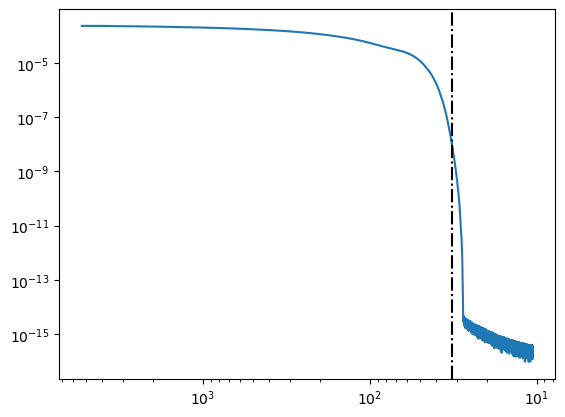

In [15]:
w = 3
plt.plot(power_spectra_MIRI[w][0], power_spectra_PSF[w][1], label=filter_name)
plt.xscale('log')
plt.yscale('log')
plt.axvline(x= (miri_psf[w] * arcsecond_to_pc), color='black', linestyle='-.')
plt.gca().invert_xaxis()

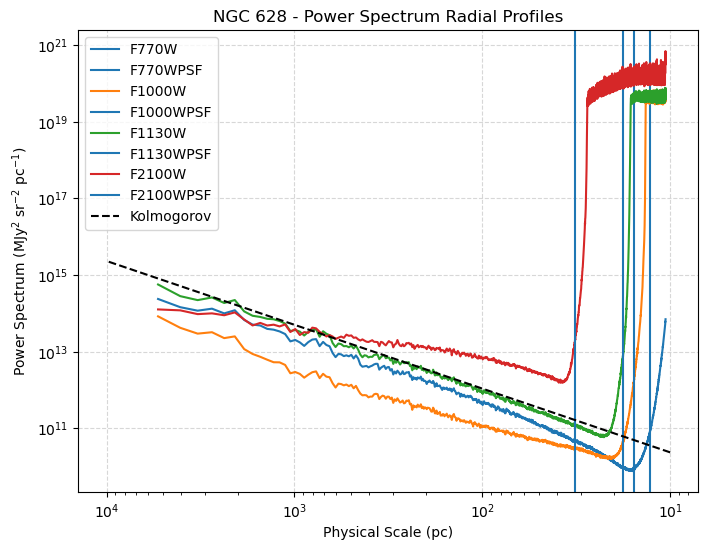

In [11]:
plt.figure(figsize=(8, 6))

for i, (filter_name, _) in enumerate(miri_images.items()):
    plt.plot(power_spectra_MIRI[i][0], power_spectra_MIRI[i][1] / power_spectra_PSF[i][1], label=filter_name)
    plt.axvline(x= (miri_psf[i] * arcsecond_to_pc), label= filter_name + 'PSF')

k_range = np.logspace(1, 4, 100)
k_line = A = 5e8 * k_range ** (5/3)
plt.plot(k_range, k_line, label="Kolmogorov", color='black', linestyle='--')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Physical Scale (pc)")
plt.ylabel("Power Spectrum (MJy$^{2}$ sr$^{-2}$ pc$^{-1}$)")
plt.title("NGC 628 - Power Spectrum Radial Profiles")
plt.gca().invert_xaxis()
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Fitting

In [289]:
def broken_power_law(k, alpha, A, beta, B, Lb):
    return np.where(k < Lb, A * k**alpha, B * k**beta)

def log_likelihood(params, k, P_obs):
    alpha, A, beta, B, Lb = params
    P_model = broken_power_law(k, alpha, A, beta, B, Lb)
    return -0.5 * np.sum((P_obs - P_model)**2)

def log_prior(params):
    alpha, A, beta, B, Lb = params
    if not (3 < alpha < 1):
        return -np.inf
    if not (1e1 < A < 1e3):
        return -np.inf
    if not (1 < beta < 2):
        return -np.inf
    if not (3e3 < B < 2e5):
        return -np.inf
    if not (10 < Lb < 50):
        return -np.inf
    return 0

def log_probability(params, k, P_obs):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, k, P_obs)

def fit_broken_power_law(k_values, P_values, filter_name, nwalkers=100, nsteps=5000, burn_in=1000, initial_params=None):
    if initial_params is None:
        if filter_name == "F770W":
            initial_params = [5/3, 2e2, 5/3, 5e4, 20]
        elif filter_name == "F1000W":
            initial_params = [5/3, 2e2, 5/3, 5e3, 25]
        elif filter_name == "F1130W":
            initial_params = [5/3, 2e2, 5/3, 5e4, 25]
        elif filter_name == "F2100W":
            initial_params = [5/3, 7e2, 5/3, 6e4, 40]
        else:
            initial_params = [5/3, 5e2, 5/3, 5e4, 25]
    initial_pos = initial_params + 8e-1 * np.random.randn(nwalkers, len(initial_params))

    sampler = emcee.EnsembleSampler(nwalkers, len(initial_params), log_probability, args=[k_values, P_values])

    sampler.run_mcmc(initial_pos, nsteps, progress=True)

    samples = sampler.get_chain(discard=burn_in, flat=True)

    alpha_best = np.median(samples[:, 0])
    A_best = np.median(samples[:, 1])
    beta_best = np.median(samples[:, 2])
    B_best = np.median(samples[:, 3])
    Lb_best = np.median(samples[:, 4])
    
    return alpha_best, A_best, beta_best, B_best, Lb_best

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 709.72it/s]


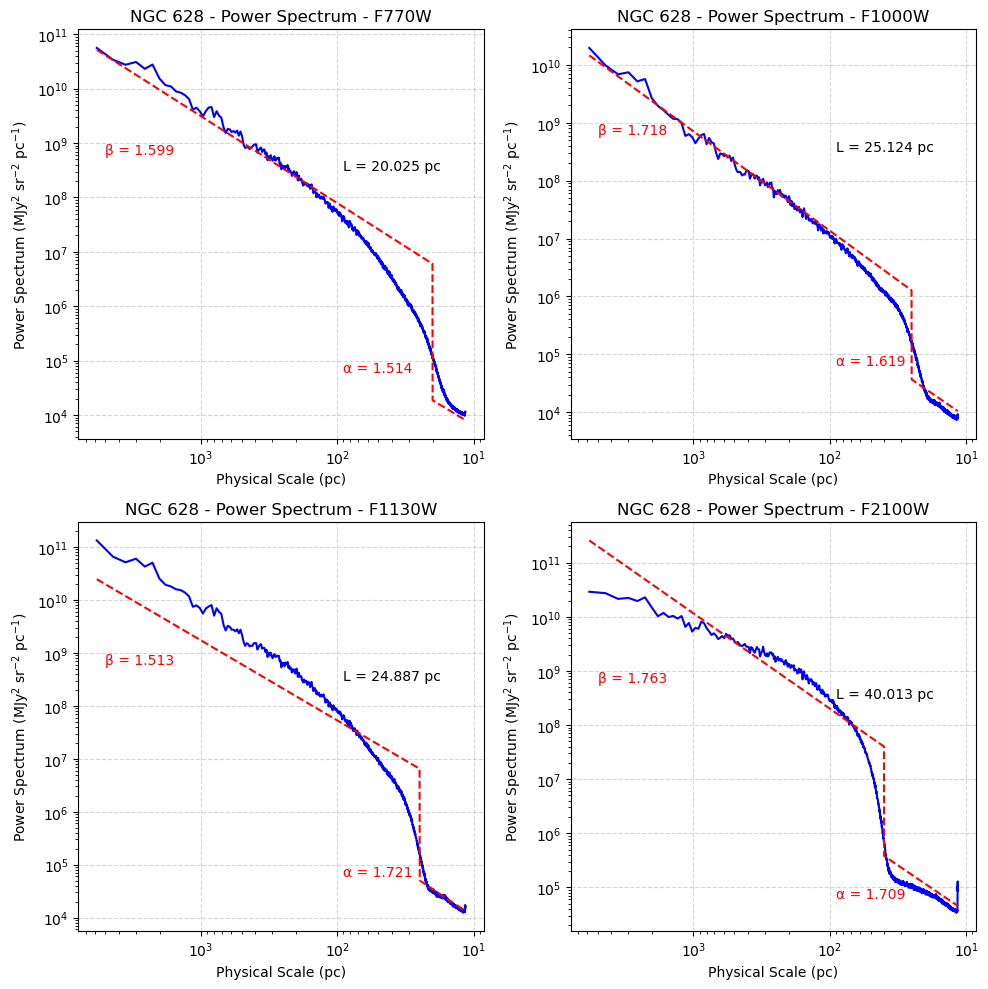

In [290]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, (filter_name, _) in enumerate(miri_images.items()):
    alpha, A, beta, B, Lb = fit_broken_power_law(power_spectra_MIRI[i][0], power_spectra_MIRI[i][1], filter_name=filter_name)
    P_fit = broken_power_law(power_spectra_MIRI[i][0], alpha, A, beta, B, Lb)
    
    ax = axes.flatten()[i]
    
    ax.plot(power_spectra_MIRI[i][0], power_spectra_MIRI[i][1], color="blue")
    ax.plot(power_spectra_MIRI[i][0], P_fit, color="red", linestyle="--")
    plt.axvline(x= (miri_psf[i] * arcsecond_to_pc), color='black', linestyle='-.')

    ax.text(9e1, 1e5, f"α = {alpha:.3f}", verticalalignment='top', horizontalalignment='left', color='red')
    ax.text(5e3, 1e9, f"β = {beta:.3f}", verticalalignment='top', horizontalalignment='left', color='red')
    ax.text(9e1, 5e8, f"L = {Lb:.3f} pc", verticalalignment='top', horizontalalignment='left', color='black')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Physical Scale (pc)")
    ax.set_ylabel("Power Spectrum (MJy$^{2}$ sr$^{-2}$ pc$^{-1}$)")
    ax.set_title(f"NGC 628 - Power Spectrum - {filter_name}")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.invert_xaxis()
plt.tight_layout()
plt.show()